# Import packages

In [24]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: eval_nav.py
# --- Creation Date: 16-02-2022
# --- Last Modified: Thu 17 Feb 2022 00:34:50 AEDT
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Evaluate Navigators with a pretrained attr discrim network.
"""
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import lpips

import legacy

In [3]:
generator_pkl = 'ffhq512'
attr_discrim_pkl = '/mnt/hpc_hdd_2/repo_results/stylegan2/results_vc2_byvae_ffhq512/00033-vc2_gan-ffhq-4gpu-config-c/converted_ps_sc/00000-convert/attr_discrim_model/00005-00012-pseudo_attr_data-attr-ch_3-dout_24-netn_resnet50-pretr_True-loss_reg-tsize_17000-kimg25000-batch64-noaug/network-snapshot-002016.pkl'
outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/compare_neigs_table2'
batch_gpu = 16
truncation_psi = 1

torch.cuda.device_count()

4

In [5]:
print('Loading generator networks from "%s"...' % generator_pkl)

resume_specs = {
    'ffhq256':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl',
    'ffhq512':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl',
    'ffhq1024':    'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl',
    'celebahq256': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/celebahq-res256-mirror-paper256-kimg100000-ada-target0.5.pkl',
    'lsundog256':  'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/lsundog-res256-paper256-kimg100000-noaug.pkl',
}

assert generator_pkl is not None
if generator_pkl in resume_specs:
    generator_pkl = resume_specs[generator_pkl] # predefined url

device = torch.device('cuda:0')
gpu_ids = list(range(torch.cuda.device_count()))
# device = torch.device('cpu')
with dnnlib.util.open_url(generator_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].requires_grad_(False) # type: ignore

def load_M(navigator_pkl):
    with open(navigator_pkl, 'rb') as f:
        resume_data = pickle.load(f)
        M = resume_data['M'].requires_grad_(False)
    return M

with open(attr_discrim_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    D = resume_data['D_ema'].requires_grad_(False)

if len(gpu_ids) > 1:
    G = nn.DataParallel(G).to(device)
    G_ref = G.module
    G_mapping = nn.DataParallel(G_ref.mapping).to(device)
    G_synthesis = nn.DataParallel(G_ref.synthesis).to(device)
    D = nn.DataParallel(D).to(device)
    D_ref = D.module
else:
    G_ref = G.to(device)
    G_mapping = G_ref.mapping.to(device)
    G_synthesis = G_ref.synthesis.to(device)
    D_ref = D.to(device)
    
print(gpu_ids)
print('Done loading.')

Loading generator networks from "ffhq512"...
[0, 1, 2, 3]
Done loading.


In [6]:
print(G_mapping)

DataParallel(
  (module): MappingNetwork(
    (fc0): FullyConnectedLayer()
    (fc1): FullyConnectedLayer()
    (fc2): FullyConnectedLayer()
    (fc3): FullyConnectedLayer()
    (fc4): FullyConnectedLayer()
    (fc5): FullyConnectedLayer()
    (fc6): FullyConnectedLayer()
    (fc7): FullyConnectedLayer()
  )
)


In [7]:
os.makedirs(outdir, exist_ok=True)

In [8]:
def show(img):
    img = (img - img.min()) / (img.max() - img.min())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [9]:
def try_var_scale_ls(M, var_scale_ls, idx, used_dims, seed=0, truncation_psi=0.3):
    torch.random.manual_seed(seed)
    z = torch.randn([1, G_ref.z_dim], device=device)
    c = torch.randn([1, G_ref.c_dim], device=device)
    w = G_ref.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)
    dirs = M(w) # [b, nv_dim, num_ws, w_dim]
    print('dirs.shape', dirs.shape)
    w_1 = w - dirs[:, used_dims[idx]] * var_scale_ls[idx]
    w_2 = w + dirs[:, used_dims[idx]] * var_scale_ls[idx] # [b, num_ws, w_dim]
    print(idx)
    image = G_ref.synthesis(w_1, noise_mode='const')
    image_2 = G_ref.synthesis(w_2, noise_mode='const')
    print(image.shape)

    show(torch.cat([image, image_2], dim=3)[0].cpu())
# try_var_scale_ls(M, var_scale_ls=[1] * M.nv_dim, idx=0, seed=20)

In [10]:
# Eval for each variation dim
# var_scale_ls = [5, 1, 1, 1, 5, 3, 1, 3, 5, 5]
#var_scale_ls = [1] * M.nv_dim

def evaluate_model(G, M, D, var_scale_ls=[2]*30, used_dims=[1,2,3], truncation_psi=0.5, n_samples_per=500, batch_gpu=16):
    attr_score_shift_summary_ls = []
    img_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
    rand_state = np.random.RandomState()
    for i, dim in enumerate(used_dims):
        attr_score_shift_ls = []
        print(f'Processing dim {i}')
        for j in range(0, n_samples_per, batch_gpu):
            b = batch_gpu if j+batch_gpu <= n_samples_per else n_samples_per-j

            z = torch.from_numpy(rand_state.randn(b, G_ref.z_dim)).to(device)
            c = torch.from_numpy(rand_state.randn(b, G_ref.c_dim)).to(device)
            w = G_mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)

            dirs = M(w) # [b, nv_dim, num_ws, w_dim]
#             print('dirs.shape:', dirs.shape)
#             print('var_scale_ls:', var_scale_ls)
#             print('dim:', dim)
#             print('i:', i)
            w_1 = w - dirs[:, dim] * var_scale_ls[i]
            w_2 = w + dirs[:, dim] * var_scale_ls[i] # [b, num_ws, w_dim]

            images = torch.cat([G_synthesis(w_1, noise_mode='const'),
                                G_synthesis(w_2, noise_mode='const')], dim=0) # (2b, c, h, w)
        
            # Normalize to fit model D
            # images_flat = images.view(2*b, -1)
            # img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
            # images = (images - img_min.view(2*b, 1, 1, 1)) / (img_max - img_min).view(2*b, 1, 1, 1)
            images = (images + 1.) / 2. # From [-1, 1] to [0, 1]
            images = (images - img_mean) / img_std
        
            attr_pred = D(images) # [2b, nlabel]
            attr_score_shift = attr_pred[b:] - attr_pred[:b] # [b, nlabel]
            attr_score_shift_ls.append(attr_score_shift.to('cpu'))
        attr_score_shift_i = torch.cat(attr_score_shift_ls, dim=0).mean(0) # [nlabel]
        attr_score_shift_summary_ls.append(attr_score_shift_i)
    return attr_score_shift_summary_ls

In [11]:
def summarize(attr_score_shift_summary_ls, outdir, name='pca'):
    attr_score_shift_summary = torch.stack(attr_score_shift_summary_ls, dim=0) # [nv_dim, nlabel]
    print(attr_score_shift_summary.shape)

    scores_np = np.abs(attr_score_shift_summary.numpy())
    scores_normed = scores_np[:, used_attr_idx] / scores_np[:, used_attr_idx].max(axis=1, keepdims=True)
    
    scores_copy = scores_np.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:30, -1] - scores_copy[:30, -2]).mean()
    print('before normed:', score)
    
    scores_copy = scores_normed.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:30, -1] - scores_copy[:30, -2]).mean()
    print('after normed:', score)
    
    attr_discovered = (scores_normed[:30] == 1.).any(axis=0)
    n_discovered = attr_discovered.sum()
    print('attr_discovered:', attr_discovered)
    print('n_discovered:', n_discovered)
    
    plt.clf()
    plt.imshow(scores_normed[:30], cmap='viridis')
    # plt.imshow(scores_np[:30], cmap='viridis')
    plt.colorbar()
    #plt.show()
    plt.savefig(os.path.join(outdir, f'attr_score_shift_{name}.pdf'))
    np.savetxt(os.path.join(outdir, f"scores_raw_{name}.csv"), scores_np, delimiter=",")
    np.savetxt(os.path.join(outdir, f"scores_normed_{name}.csv"), scores_normed, delimiter=",")
    np.savetxt(os.path.join(outdir, f"score_{name}.csv"), score[np.newaxis], delimiter=",")
    np.savetxt(os.path.join(outdir, f"n_discovered_{name}.csv"), n_discovered[np.newaxis], delimiter=",")
    return score

In [12]:
# used_dims = argsort_percept(G, M, D)
def argsort_percept(G, M, n_samples_dim=100, batch_gpu=16):
    if len(gpu_ids) > 1:
        pnet = nn.DataParallel(lpips.LPIPS(net='alex', lpips=False)).to(device)
    else:
        pnet = lpips.LPIPS(net='alex', lpips=False).to(device)
    img_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
    rand_state = np.random.RandomState()
    percept_ls = []
    for i in range(M_ref.nv_dim):
        # print('computing dim:', i)
        diff_ls_i = []
        for j in range(0, n_samples_dim, batch_gpu):
            b = batch_gpu if j+batch_gpu <= n_samples_per else n_samples_per-j

            z = torch.from_numpy(rand_state.randn(b, G_ref.z_dim)).to(device)
            c = torch.from_numpy(rand_state.randn(b, G_ref.c_dim)).to(device)
            w = G_mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)

            # print(M.device)
            # print(w.device)
            dirs = M(w) # [b, nv_dim, num_ws, w_dim]
            w_1 = w - dirs[:, i]
            w_2 = w + dirs[:, i] # [b, num_ws, w_dim]

            images = torch.cat([G_synthesis(w_1, noise_mode='const'),
                                G_synthesis(w_2, noise_mode='const')], dim=0) # (2b, c, h, w)
        
            # Normalize to fit model D
            # images_flat = images.view(2*b, -1)
            # img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
            # images = (images - img_min.view(2*b, 1, 1, 1)) / (img_max - img_min).view(2*b, 1, 1, 1)
            images = (images + 1.) / 2. # From [-1, 1] to [0, 1]
            images = (images - img_mean) / img_std
            
            diff = pnet(images[:b], images[b:]).squeeze() # [b]
            diff_ls_i.append(diff.to('cpu'))
        # print(diff_ls_i)
        diff_i_sum = torch.cat(diff_ls_i, dim=0).sum()
        percept_ls.append(diff_i_sum)
    percept = torch.tensor(percept_ls, device=device)
    _, idx_sort = torch.sort(percept, descending=True)
    return idx_sort
        

In [20]:
attr_names = ['azimuth',#0
                'haircolor',#1
                'smile',#2
                'gender',#3
                'main_fringe',#4
                'left_fringe',#5
                'age',#6
                'light_right',#7
                'light_left',#8
                'light_vertical',#9
                'hair_style',#10
                'clothes_color',#11
                'saturation',#12
                'ambient_color',#13
                'elevation',#14
                'neck',#15
                'right_shoulder',#16
                'left_shoulder',#17
                'background_1',#18
                'background_2',#19
                'background_3',#20
                'background_4',#21
                'right_object',#22
                'left_object']#23
# used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17] # more accurate
used_attr_idx = list(range(24))
pt_models = [
    '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pt_neig_table2_ffhq512/00001-ffhq512-z_30-lr_0.05-vars_1-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_30-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-kimg200-batch10/network-snapshot-000200.pkl',
    '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pt_neig_table2_ffhq512/00002-ffhq512-z_30-lr_0.05-vars_1-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-kimg200-batch10/network-snapshot-000200.pkl',
    '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pt_neig_table2_ffhq512/00003-ffhq512-z_30-lr_0.05-vars_1-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_300-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-kimg200-batch10/network-snapshot-000200.pkl',
    '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pt_neig_table2_ffhq512/00004-ffhq512-z_30-lr_0.05-vars_1-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_500-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-kimg200-batch10/network-snapshot-000200.pkl'
]

bi_models = [
    '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_bi_neig_table2_ffhq512/00000-ffhq512-z_30-lr_0.05-vars_1-wals_0.3-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_30-afc_3-nfc_3-atl_16-atg_3-cont_1-pos_1-neg_1-div_0.1-ncol_2-dys_T-kimg200-batch12/network-snapshot-000200.pkl',
    '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_bi_neig_table2_ffhq512/00001-ffhq512-z_30-lr_0.05-vars_1-wals_0.3-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_1-pos_1-neg_1-div_0.1-ncol_2-dys_T-kimg200-batch12/network-snapshot-000200.pkl',
    '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_bi_neig_table2_ffhq512/00002-ffhq512-z_30-lr_0.05-vars_1-wals_0.3-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_300-afc_3-nfc_3-atl_16-atg_3-cont_1-pos_1-neg_1-div_0.1-ncol_2-dys_T-kimg200-batch12/network-snapshot-000200.pkl',
    '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_bi_neig_table2_ffhq512/00003-ffhq512-z_30-lr_0.05-vars_1-wals_0.3-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_500-afc_3-nfc_3-atl_16-atg_3-cont_1-pos_1-neg_1-div_0.1-ncol_2-dys_T-kimg200-batch12/network-snapshot-000040.pkl'
]

neigs = [30, 100, 300, 500]
# neigs = [30]

Processing dim 0
Processing dim 1
Processing dim 2
Processing dim 3
Processing dim 4
Processing dim 5
Processing dim 6
Processing dim 7
Processing dim 8
Processing dim 9
Processing dim 10
Processing dim 11
Processing dim 12
Processing dim 13
Processing dim 14
Processing dim 15
Processing dim 16
Processing dim 17
Processing dim 18
Processing dim 19
Processing dim 20
Processing dim 21
Processing dim 22
Processing dim 23
Processing dim 24
Processing dim 25
Processing dim 26
Processing dim 27
Processing dim 28
Processing dim 29
torch.Size([30, 24])
before normed: 0.028053025
after normed: 0.3199183
attr_discovered: [False  True  True False False  True  True  True  True False False False
  True  True  True  True  True False  True  True False  True False False]
n_discovered: 14
--- Done summary for pt 0
Processing dim 0
Processing dim 1
Processing dim 2
Processing dim 3
Processing dim 4
Processing dim 5
Processing dim 6
Processing dim 7
Processing dim 8
Processing dim 9
Processing dim 10
Pro

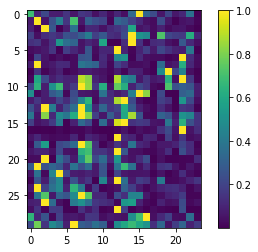

In [22]:
# === contra with att large
var_scale_ls = [0.1] * 30

for mname, pklls in zip(['pt', 'bi'], [pt_models, bi_models]):
    for i, (neig, pkl) in enumerate(zip(neigs, pklls)):
        out_path = os.path.join(outdir, mname, str(neig))
        os.makedirs(out_path, exist_ok=True)
        M = load_M(pkl)
        M_ref = M.to(device)
        # used_dims = argsort_percept(G, M, n_samples_dim=20, batch_gpu=16)
        used_dims = list(range(30))
        # print(f'Done argsort_percept for {mname} {i}')
        tmp_attr_ls = evaluate_model(G, M, D, var_scale_ls=var_scale_ls, used_dims=used_dims,
                                     n_samples_per=500, batch_gpu=64)
        tmp_score = summarize(tmp_attr_ls, out_path, name='neig_table2')
        print(f'--- Done summary for {mname} {i}')
    print(f'=== Done {mname}')

In [65]:
used_dims = argsort_percept(G, M, n_samples_dim=20, batch_gpu=16) # [4,2,6,10]
# used_dims = list(range(10))
print('used_dims:', used_dims)

Setting up [baseline] perceptual loss: trunk [alex], v[0.1], spatial [off]
computing dim: 0
cuda:0
cuda:0
[tensor([5.9042, 6.0644, 6.5902, 5.2111, 5.9136, 5.1381, 5.9172, 4.3068, 4.7667,
        5.7376, 6.3456, 5.4547, 6.3364, 6.5566, 5.5390, 4.9970]), tensor([4.8625, 4.8845, 7.0443, 6.7615, 4.9087, 6.3030, 5.5374, 5.3263, 4.6318,
        5.6603, 5.3379, 3.4418, 5.0469, 5.0634, 6.4010, 6.1387])]
computing dim: 1
cuda:0
cuda:0
[tensor([0.7873, 0.3076, 0.1653, 0.6840, 0.4570, 0.6197, 0.5011, 0.5149, 0.3091,
        0.6111, 0.1563, 0.3760, 0.3885, 0.7072, 0.3819, 0.6164]), tensor([0.5639, 0.2016, 0.3281, 0.6224, 0.5049, 0.3096, 0.2892, 0.5365, 0.3688,
        0.1727, 0.2390, 0.4222, 0.4442, 0.5935, 0.3021, 0.5921])]
computing dim: 2
cuda:0
cuda:0
[tensor([0.0907, 0.2777, 0.3282, 0.2214, 0.1998, 0.2626, 0.4156, 0.2037, 0.1843,
        0.1769, 0.2054, 0.1877, 0.2874, 0.1308, 0.2762, 0.2187]), tensor([0.4650, 0.2358, 0.2425, 0.2406, 0.2127, 0.2602, 0.1844, 0.1737, 0.2286,
        0.1897, 0.2

cuda:0
[tensor([6.9347, 6.4338, 8.0521, 6.8855, 7.0426, 6.9325, 7.0700, 7.0989, 7.6085,
        7.2018, 7.1943, 7.3041, 7.0885, 7.0524, 7.5249, 7.4537]), tensor([7.4389, 7.9854, 7.0926, 6.9620, 6.9613, 7.3424, 6.9638, 7.6549, 6.8630,
        7.2600, 7.5157, 7.6169, 7.6572, 7.1859, 7.5507, 6.9755])]
computing dim: 26
cuda:0
cuda:0
[tensor([3.7561, 3.9963, 4.9603, 4.6803, 3.4420, 5.3712, 4.7042, 3.6528, 4.8672,
        4.3814, 4.0824, 4.0353, 4.8046, 3.3146, 5.4243, 4.3112]), tensor([5.3184, 4.4121, 4.6473, 5.5002, 4.6677, 5.0455, 2.8630, 5.6328, 4.7286,
        5.3530, 3.6816, 4.3206, 4.6870, 6.3920, 3.9079, 4.6470])]
computing dim: 27
cuda:0
cuda:0
[tensor([3.2678, 2.3289, 2.4940, 2.8276, 3.5505, 3.1928, 2.5263, 2.6669, 4.0209,
        3.1062, 2.9919, 2.9497, 2.5909, 3.1004, 2.8184, 2.6011]), tensor([2.9755, 3.1230, 2.4640, 3.4658, 3.3693, 3.4362, 2.3033, 3.9416, 3.4570,
        2.9174, 2.8477, 2.3198, 2.7952, 2.6176, 2.4755, 2.4773])]
computing dim: 28
cuda:0
cuda:0
[tensor([0.7182, 0

dirs.shape torch.Size([1, 32, 16, 512])
18
torch.Size([1, 3, 512, 512])


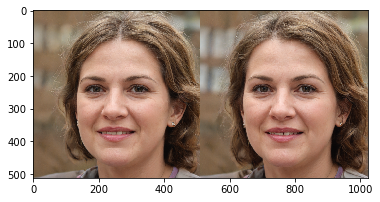

In [113]:
# === pca_base
# pca_used_dims = used_dims
# pca_var_scale_ls = [3,3,3,3,3,
#                    3,3,3,3,3,]
# try_var_scale_ls(M, var_scale_ls=pca_var_scale_ls, used_dims=pca_used_dims, idx=9, seed=2001)
# print(pca_used_dims)

# === pca_att
# pcaatt_used_dims = used_dims
# pcaatt_var_scale_ls = [1,0.5,1,1,1,
#                        1,3,3,3,3,]
# try_var_scale_ls(M, var_scale_ls=pcaatt_var_scale_ls, used_dims=pcaatt_used_dims, idx=9, seed=302)

# === contra with att
contra_used_dims = used_dims
contra_var_scale_ls = [0.7,0.7,1,1,1,
                      0.5,0.5,1,0.7,0.7,
                      0.5,0.5,0.5,0.5,0.5,
                      0.5,1,1,3,3]
try_var_scale_ls(M, var_scale_ls=contra_var_scale_ls, used_dims=contra_used_dims, idx=18, seed=1101)

# === contra-2
# contra2_used_dims = used_dims
# contra2_var_scale_ls = [0.5,0.5,0.5,0.5,0.7,0.5,
#                        0.5,0.5,1,1,0.5,0.7,
#                        0.5,1,1,0.5,1,1,
#                        0.5,0.5,0.7,0.5,0.5,1,
#                        0.5,1,0.5,0.7,1,0.7,]
# try_var_scale_ls(M, var_scale_ls=contra2_var_scale_ls, used_dims=contra2_used_dims, idx=29, seed=31)

# === sefa_base
# sefa_used_dims = used_dims
# sefa_var_scale_ls = [2,2,3,3,3,
#                     3,3,3,3,3,]
# try_var_scale_ls(M, var_scale_ls=sefa_var_scale_ls, used_dims=sefa_used_dims, idx=9, seed=2013)

# === sefa_att
# sefaatt_used_dims = used_dims
# sefaatt_var_scale_ls = [1,0.7,1,1,3,
#                         0.5,0.5,0.5,1,0.5,]
# try_var_scale_ls(M, var_scale_ls=sefaatt_var_scale_ls, used_dims=sefaatt_used_dims, idx=9, seed=2011)

# recog_var_scale_ls = [0.5,0.5,0.5,0.5,0.5,5,
#                       5,0.5,0.5,5,0.5,0.5,
#                       1,0.5,0.5,0.3,0.5,0.5,
#                       5,1,1,0.5,0.5,5,
#                       0.5,0.3,0.3,0.5,0.5,5]
# try_var_scale_ls(M, var_scale_ls=recog_var_scale_ls, idx=29, seed=2016)

In [114]:
# pca_attr_ls = evaluate_model(G, M, D, var_scale_ls=pca_var_scale_ls, used_dims=pca_used_dims[:len(pca_var_scale_ls)], batch_gpu=64)
# pcaatt_attr_ls = evaluate_model(G, M, D, var_scale_ls=pcaatt_var_scale_ls, used_dims=pcaatt_used_dims[:len(pcaatt_var_scale_ls)], batch_gpu=64)
contra_attr_ls = evaluate_model(G, M, D, var_scale_ls=contra_var_scale_ls, used_dims=contra_used_dims[:len(contra_var_scale_ls)], batch_gpu=64)
# contra2_attr_ls = evaluate_model(G, M, D, var_scale_ls=contra2_var_scale_ls, used_dims=contra2_used_dims[:len(contra2_var_scale_ls)])
# sefa_attr_ls = evaluate_model(G, M, D, var_scale_ls=sefa_var_scale_ls, used_dims=sefa_used_dims[:len(sefa_var_scale_ls)], batch_gpu=64)
# sefaatt_attr_ls = evaluate_model(G, M, D, var_scale_ls=sefaatt_var_scale_ls, used_dims=sefaatt_used_dims[:len(sefaatt_var_scale_ls)], batch_gpu=64)
# recog_attr_ls = evaluate_model(G, M, D, var_scale_ls=recog_var_scale_ls, used_dims=list(range(30)))

Processing dim 0
Processing dim 1
Processing dim 2
Processing dim 3
Processing dim 4
Processing dim 5
Processing dim 6
Processing dim 7
Processing dim 8
Processing dim 9
Processing dim 10
Processing dim 11
Processing dim 12
Processing dim 13
Processing dim 14
Processing dim 15
Processing dim 16
Processing dim 17
Processing dim 18
Processing dim 19


In [117]:
def load_summary(name, limit=30, used_attr_idx=list(range(24))):
    scores_np = np.loadtxt(os.path.join(outdir, f"scores_raw_{name}.csv"), delimiter=",")
    scores_normed = np.loadtxt(os.path.join(outdir, f"scores_normed_{name}.csv"), delimiter=",")
    # score = np.loadtxt(os.path.join(outdir, f"score_{name}.csv"), delimiter=",")
    n_disc = np.loadtxt(os.path.join(outdir, f"n_discovered_{name}.csv"), delimiter=",")
    
    # scores_normed = scores_normed[:, used_attr_idx]
    scores_normed = scores_np[:, used_attr_idx] / scores_np[:, used_attr_idx].max(axis=1, keepdims=True)
    scores_np = scores_np[:, used_attr_idx]

    scores_copy = scores_np.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:limit, -1] - scores_copy[:limit, -2]).mean()
    print('before normed:', score)
    
    scores_copy = scores_normed.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:limit, -1] - scores_copy[:limit, -2]).mean()
    print('after normed:', score)
    
    attr_discovered = (scores_normed[:limit] == 1.).any(axis=0)
    n_discovered = attr_discovered.sum()
    print('attr_discovered:', attr_discovered)
    print('n_discovered:', n_discovered)
    
    plt.clf()
    plt.imshow(scores_normed[:limit], cmap='viridis')
    # plt.imshow(scores_np[:30], cmap='viridis')
    plt.colorbar()
    #plt.show()
    return score

before normed: 0.09083994720131158
after normed: 0.2444130660810738
attr_discovered: [ True  True False  True  True False False  True False False False False
 False  True  True  True  True False  True False False  True False False]
n_discovered: 11


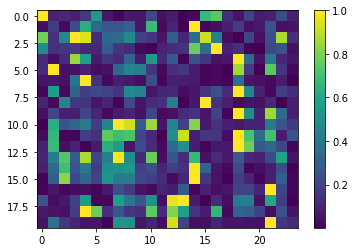

In [124]:
# contra_score = summarize(contra_attr_ls, name='contra_table1')
# contra_score = load_summary('contra_table1', limit=15, used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17])
contra_score = load_summary('contra_table1', limit=20)

before normed: 0.12115647345781326
after normed: 0.3540064239151624
attr_discovered: [ True False False  True False False False False False False False False
 False False  True False False False  True  True False False False False]
n_discovered: 5


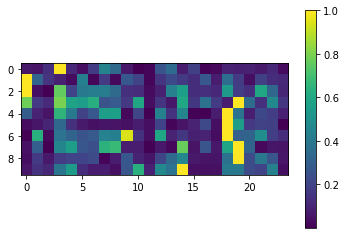

In [97]:
# pca_score = summarize(pca_attr_ls, name='pca_table1')
# pca_score = load_summary('pca_table1', limit=10, used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17])
pca_score = load_summary('pca_table1', limit=10)

before normed: 0.12943251058459282
after normed: 0.3828692832693401
attr_discovered: [ True False False  True False False False False False False False False
  True False  True  True False False False  True False  True False False]
n_discovered: 7


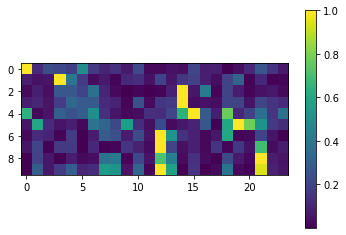

In [98]:
# pcaatt_score = summarize(pcaatt_attr_ls, name='pcaatt_table1')
# pcaatt_score = load_summary('pcaatt_table1', limit=10, used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17])
pcaatt_score = load_summary('pcaatt_table1', limit=10)

before normed: 0.08148508220911026
after normed: 0.21499987204867943
attr_discovered: [ True False False  True False False False False  True False False False
  True False False False False False  True  True False  True False False]
n_discovered: 7


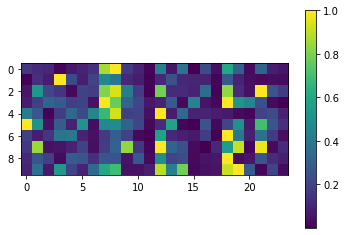

In [100]:
# sefa_score = summarize(sefa_attr_ls, name='sefa_table1')
sefa_score = load_summary('sefa_table1', limit=10)

before normed: 0.08228555917739869
after normed: 0.26949817269224596
attr_discovered: [ True False False False  True  True False False False False False False
  True False  True False False False False False False  True False False]
n_discovered: 6


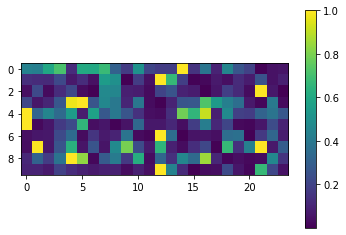

In [129]:
# sefaatt_score = summarize(sefaatt_attr_ls, name='sefaatt_table1')
sefaatt_score = load_summary('sefaatt_table1', limit=10)

before normed: 0.05394036769866943
after normed: 0.2222164215175714
attr_discovered: [ True False False  True  True False False False False  True False False
  True False  True False  True False  True False False False False False]
n_discovered: 8


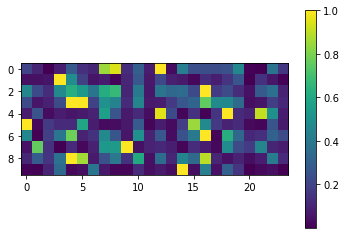

In [166]:
# sefaatt2_score = summarize(sefaatt_attr_ls, name='sefaatt2_table1')
sefaatt2_score = load_summary('sefaatt2_table1', limit=10)